# 轮廓检测

轮廓检测是图像处理中的常见技术，用于在**二值化图像**中查找物体边缘。

原理是在二值化图像中查找所有的连续白色像素区域，然后在这些像素区域中查找物体边缘。

具体上，采用**铃木算法**实现轮廓的查找。

从二值化图像的一个像素点开始，按顺时针和逆时针的方向依次遍历边缘上的像素点

完成一次遍历，算法返回起始点，继续查找下一个轮廓。(深度搜索原理)

同时，采用了链表序列来存储边缘，可通过比较相邻像素点的位置关系来确定当前像素点的边缘方向，节省存储空间。

此外，还采用了一些优化技术，如空间分配策略，边缘跟踪、内存池等策略来优化。

opencv提供了封装好的函数来实现轮廓查找

即cv2.findContours

`contours, hierarchy = cv2.findContours(image, mode, method)`


输入
* img: 二值图像
* mode: 轮廓查找模式
* method: 轮廓近似方法

返回
* contours: 轮廓点集
* hierarchy: 轮廓层级关系

mode参数用于查找轮廓的模式，包括：

* cv2.RETR_EXTERNAL: 只检测外部轮廓
* cv2.RETR_LIST: 检测所有轮廓并存储列表，但不建立轮廓关系
* cv2.RETR_CCOMP: 检测所有轮过，建立两层关系
* cv2.RETR_TREE：检测所有轮廓，并建立完整的层级关系。


method参数用于指定轮廓近似方法。包括：
* cv2.CHAIN_APPROX_NONE：保存所有的轮廓点。
* cv2.CHAIN_APPROX_SIMPLE：只保存轮廓的拐点，对于直线段只保存端点。

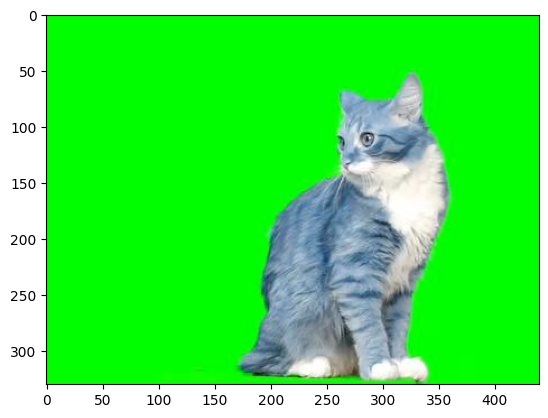

In [51]:
# 一个简单的示例
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("../../dataset/cat.jpeg")
plt.imshow(img)
plt.show()

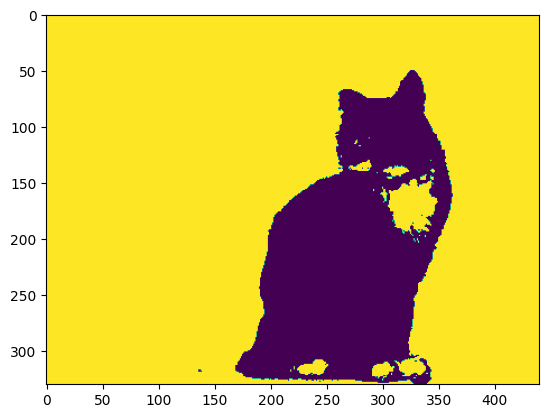

In [52]:
_, binary_img = cv2.threshold(img[:, :, 1], 240, 255, cv2.THRESH_BINARY)
plt.imshow(binary_img)
plt.show()

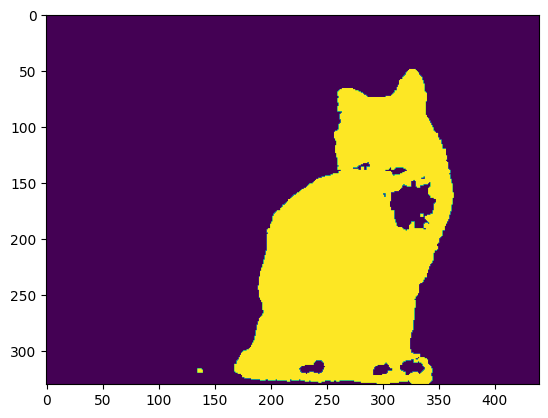

In [53]:
dilate_img = cv2.dilate(255 - binary_img, np.ones((3, 3), np.uint8))
plt.imshow(dilate_img)

In [54]:
contours, hierarchy = cv2.findContours(dilate_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

2


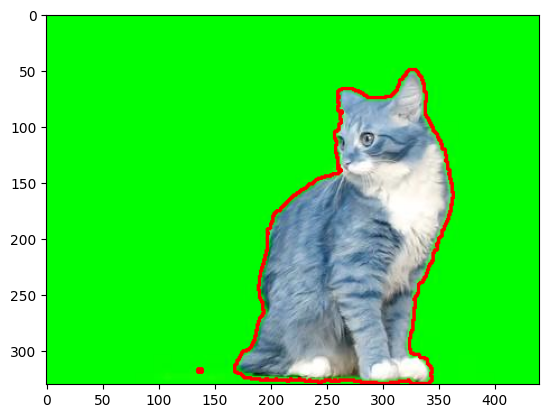

In [55]:
new_img = cv2.drawContours(img, contours, -1, (255, 0, 0), 2)
plt.imshow(new_img)
plt.show()

最后，需要去除一些小的零散轮廓。

In [56]:
new_contours = []

for contour in contours:
    area = cv2.contourArea(contour)
    if area >= 100:
        new_contours.append(contour)

print(len(new_contours))

1


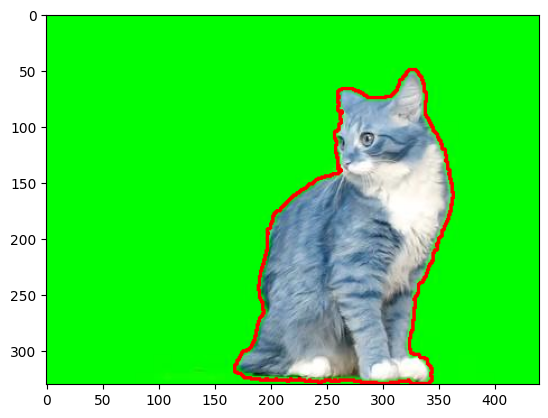

In [57]:
new_img = cv2.drawContours(cv2.imread("../../dataset/cat.jpeg"), new_contours, -1, (255, 0, 0), 2)
plt.imshow(new_img)
plt.show()

实际上，上述内容并没有检测内部轮廓，通过更改mode来实现内部轮廓的检测

In [60]:
contours, hierarchy = cv2.findContours(dilate_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours), hierarchy)
print(contours[11])

15 [[[ 1 -1 -1 -1]
  [-1  0  2 -1]
  [ 3 -1 -1  1]
  [ 4  2 -1  1]
  [ 5  3 -1  1]
  [ 6  4 -1  1]
  [ 7  5 -1  1]
  [ 8  6 -1  1]
  [ 9  7 -1  1]
  [10  8 -1  1]
  [12  9 11  1]
  [-1 -1 -1 10]
  [13 10 -1  1]
  [14 12 -1  1]
  [-1 13 -1  1]]]
[[[334 178]]

 [[334 180]]

 [[336 180]]

 [[336 178]]]


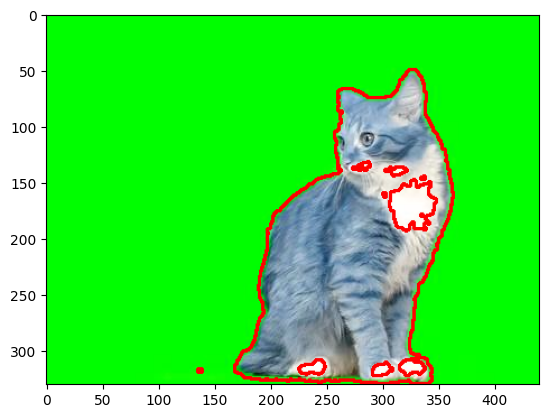

In [24]:
new_img = cv2.drawContours(cv2.imread("../../dataset/cat.jpeg"), contours, -1, (255, 0, 0), 2)
plt.imshow(new_img)
plt.show()

其中hierarchy包含了每个轮廓的父子关系

作为一个np数组，每一行表示一个轮廓的关系，包含了4个整数，分别表示后一个轮廓，前一个轮廓，子轮廓，父轮廓的索引。

如果不存在响应关系，则为-1.

例如，第二个轮廓的hierarchy是[-1, 0, 2, -1]

说明其没有后一个轮廓，其前一个轮廓索引是0，子轮廓是2，父轮廓没有。

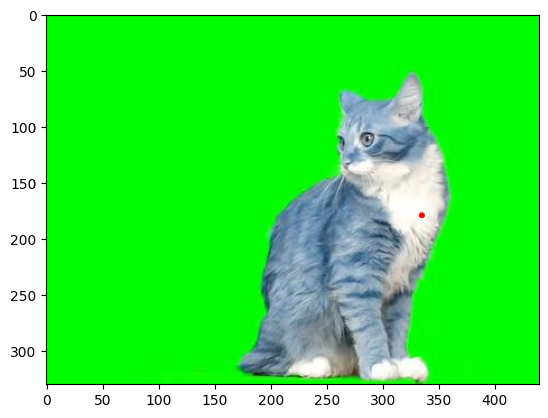

In [37]:
new_img = cv2.drawContours(cv2.imread("../../dataset/cat.jpeg"), [contours[11]], -1, (255, 0, 0), 2)
plt.imshow(new_img)
plt.show()

我们仔细观察轮廓，可以发现他的表示是一连串有顺序的点的坐标。

这些点的坐标连起来，就形成了轮廓。

但有时，这些轮廓点过于冗余，可以对其进行压缩处理。(例如，一条直线上会用多个点进行表示， 但实际只需要将其压缩为2个点即可)

即用更少的点来表示轮廓。

原理：多边形近似

将一个形状用多边形近似，只记录角点即可。

`cv2.approxPolyDP(contour, epsilopn, closed)`

In [38]:
print(contours[1].shape)

(383, 1, 2)


(21, 1, 2)


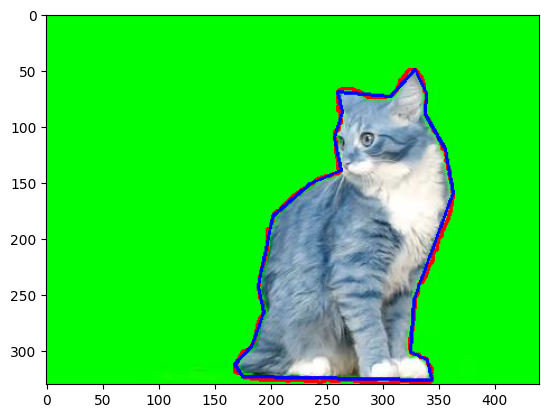

In [49]:
epsilon = 0.005 * cv2.arcLength(contours[1], True)
approx = cv2.approxPolyDP(contours[1], epsilon, True)

print(approx.shape)


img = cv2.imread("../../dataset/cat.jpeg")
cv2.drawContours(img, [contours[1]], -1, (255, 0, 0), 2)
cv2.drawContours(img, [approx], -1, (0, 0, 255), 2)

plt.imshow(img)
plt.show()

通常，对于检测任务来说，轮廓并不是最终输出。有时需要计算轮廓的外接矩形。

如何寻找外接矩形？确定四个点的坐标。

采用函数boundingRect即可得到外接矩形。

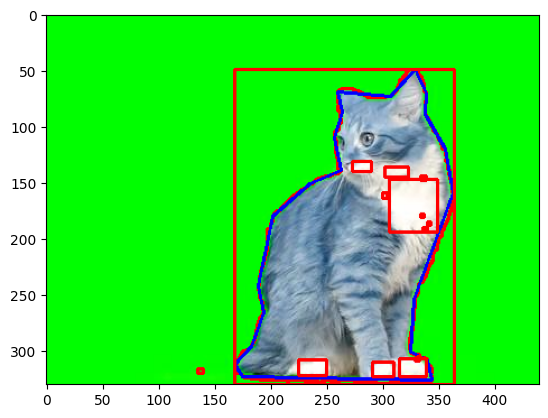

In [50]:
for cn in contours:
    x, y, w, h = cv2.boundingRect(cn)
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.imshow(img)
plt.show()

**小结**：

轮廓检测，是没有采用深度学习的时候，实现物体检测的关键工具。

通过各种操作，来得到较好的轮廓

并通过轮廓筛选，来剔除噪声干扰。

最终通过外接矩形，来得到物体的目标框。